In [15]:
import joblib
import numpy as np

# HYERPARAMETERS
FILEPATH = '/Users/andreaalberti/Desktop/Public_Projects/advanced-biomedical-project/dataset/murmurs_4000/abnormal_s3_2023_18.wav'

SEED = 42
INTERVAL = 1

BALANCING_TYPE = "none"
RESULT_NAME = f"results_ensemble_v4_best_features_{BALANCING_TYPE}.csv"
CM_NAME = f"cm_ensemble_v4_best_features_{BALANCING_TYPE}.csv"
mod = "../../models/MLP_rollercoaster_none.joblib"

# set the paths
BASE_DIR = "../../dataset/"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + "raw/"
# FEATURES = FEATURES_BASE + 'balanced/posteriori/'


# Models
MODELS_PATH = "../../models/"
MODELS_RESULTS = MODELS_PATH + "results/"
BEST_MODEL = MODELS_PATH + f"MLP_rollercoaster_{BALANCING_TYPE}.joblib"
# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"


# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = [4000]
num_feats = {
    "30 MFCC": "28mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "0cqt",
    "40 RMS": "0rms",
    "40 Zero Crossing Rates": "1zcr",
    "40 Spectral Centroid": "0sc",
    "60 Spectral Bandwidth": "0sb",
    "40 Spectral Rolloff": "0sr",
}

COMPLETE_DATA_PRIOR_CORR_NAME = (
    f"full_data_filtered_{INTERVAL}s_4000hz_"
    + "_".join(numvalue for _, numvalue in num_feats.items())
    + ".npy"
)
# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data["train"]["X"].shape[1]

model = joblib.load(BEST_MODEL)

X_train = full_data["train"]["X"]
y_train = full_data["train"]["y"]
X_test = full_data["test"]["X"]
y_test = full_data["test"]["y"]

features_name = full_data["features"]

In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import permutation_importance
import librosa
import librosa.display
import matplotlib.pyplot as plt
import shap

# Define the model (as per your provided model)
SEED = 42
voting_clf = VotingClassifier(estimators=[
    ("RandomForest", RandomForestClassifier(random_state=SEED)),
    ("MLP_Ultra",MLPClassifier(hidden_layer_sizes=(512,256,128,64,32,),activation="relu",solver="adam",random_state=SEED,),),
    ("MLP_Rollercoaster",MLPClassifier(hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32),activation="relu",solver="adam",random_state=SEED,),),],
    voting="soft",)

# Assuming X_train and y_train are your training data and labels
# Train the model
voting_clf.fit(X_train, y_train)

# Compute permutation importance
perm_importance = permutation_importance(voting_clf, X_train, y_train, n_repeats=30, random_state=SEED)

# Identify the most important MFCCs
sorted_idx = perm_importance.importances_mean.argsort()
important_mfccs = sorted_idx[-5:]  # Get indices of the top 5 important MFCCs
print("Important MFCC indices:", important_mfccs)


Important MFCC indices: [5 2 3 1 0]


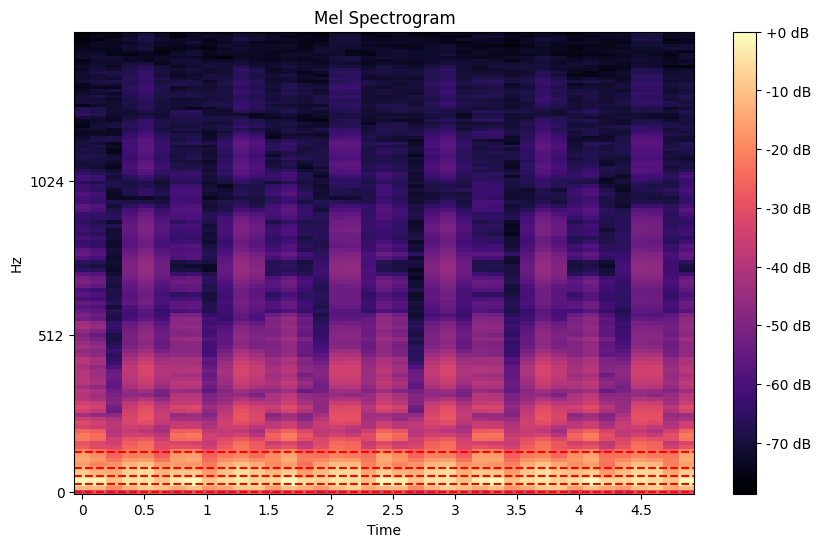

In [17]:
def plot_mfcc_to_spectrogram(audio, sr=4000, important_mfccs=None):
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    
    # Compute Mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)
    
    # Plot Mel spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    
    # Highlight regions corresponding to important MFCCs
    if important_mfccs is not None:
        for mfcc in important_mfccs:
            # Map MFCC to corresponding frequency bin
            freq_bin = int(librosa.mel_frequencies(n_mels=128)[mfcc])
            plt.axhline(y=freq_bin, color='r', linestyle='--')
    
    plt.show()

# Example usage
audio, sr = librosa.load(FILEPATH, sr=4000)
plot_mfcc_to_spectrogram(audio, sr, important_mfccs)


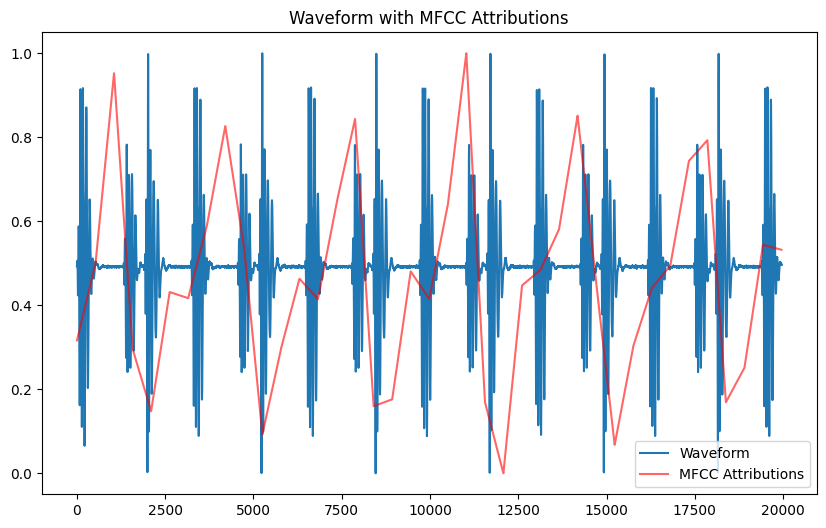

In [18]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def plot_waveform_with_mfcc_attributions(audio, sr=4000, important_mfccs=None):
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    
    # Placeholder for attributions (to be computed for the important MFCCs)
    attributions = np.zeros_like(audio)
    
    # Compute attributions (for simplicity, this example uses MFCC magnitudes as attributions)
    for mfcc in important_mfccs:
        # Reshape and stretch MFCC values to match the length of the audio
        mfcc_values = mfccs[mfcc]
        mfcc_stretched = np.interp(np.arange(len(audio)), np.linspace(0, len(audio), len(mfcc_values)), mfcc_values)
        attributions += mfcc_stretched
    
    # Normalize both waveform and attributions
    audio_norm = normalize(audio)
    attributions_norm = normalize(attributions)
    
    # Plot waveform with attributions
    plt.figure(figsize=(10, 6))
    plt.plot(audio_norm, label='Waveform')
    plt.plot(attributions_norm, label='MFCC Attributions', color='r', alpha=0.6)
    plt.legend()
    plt.title('Waveform with MFCC Attributions')
    plt.show()

# Example usage
audio, sr = librosa.load(FILEPATH, sr=4000)
important_mfccs = [2, 4, 6, 8, 10]  # Hypothetical example
plot_waveform_with_mfcc_attributions(audio, sr, important_mfccs)
